In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.utils import to_categorical
from keras.models import model_from_json

In [4]:
# Loading data
data = np.genfromtxt('train.csv', delimiter=',')
data = data[1:]

In [5]:
# sorting data in Y and X
Y = data[0: ,0]
X = data[0: ,1: ]
print(Y.shape, X.shape)

(42000,) (42000, 784)


In [11]:
# Define image dimensions
img_rows = 28
img_cols = 28
channel = 1

# Define model parameters
nb_classes = 10

#batch_size to train
batch_size = 256

# number of output classes
nb_classes = 10

# number of epochs to train
nb_epoch = 100

# number of convolutional filters to use
nb_filters_1 = 20
nb_filters_2 = 50

# size of pooling area for max pooling
nb_pool = 2

# convolution kernel size
nb_conv = 5

In [12]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 4)

In [13]:
# Using correct dimesntions for input data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# Assigning X_train and X_test as float
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Convert class vectors to binary class matrices
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10)


In [15]:
# Implementing LeNet-5
model = Sequential()

model.add(Conv2D(nb_filters_1, kernel_size = (nb_conv, nb_conv), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Conv2D(nb_filters_2, kernel_size = (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))

model.add(Dense(nb_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Optimizer used is Stochastic Gradient Descent with learning rate of 0.01
# Loss is calculated using categorical cross entropy
opt = SGD(lr = 0.01)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [17]:
hist = model.fit(X_train, Y_train, batch_size = batch_size, epochs = nb_epoch, verbose = 1, validation_split = 0.2, shuffle = True)

Instructions for updating:
Use tf.cast instead.
Train on 26880 samples, validate on 6720 samples
Epoch 1/100
26880/26880 [==============================] - 13s 498us/step - loss: 2.2167 - acc: 0.3816 - val_loss: 2.0427 - val_acc: 0.6086
Epoch 2/100
26880/26880 [==============================] - 13s 477us/step - loss: 1.3983 - acc: 0.7451 - val_loss: 0.7331 - val_acc: 0.8269
Epoch 3/100
26880/26880 [==============================] - 13s 483us/step - loss: 0.5492 - acc: 0.8530 - val_loss: 0.4242 - val_acc: 0.8804
Epoch 4/100
26880/26880 [==============================] - 13s 502us/step - loss: 0.3820 - acc: 0.8891 - val_loss: 0.3406 - val_acc: 0.9019
Epoch 5/100
26880/26880 [==============================] - 13s 499us/step - loss: 0.3202 - acc: 0.9065 - val_loss: 0.3067 - val_acc: 0.9116
Epoch 6/100
26880/26880 [==============================] - 14s 527us/step - loss: 0.2777 - acc: 0.9185 - val_loss: 0.2719 - val_acc: 0.9202
Epoch 7/100
26880/26880 [==============================] - 15s 

Epoch 57/100
26880/26880 [==============================] - 14s 537us/step - loss: 0.0442 - acc: 0.9875 - val_loss: 0.0771 - val_acc: 0.9766
Epoch 58/100
26880/26880 [==============================] - 14s 535us/step - loss: 0.0433 - acc: 0.9883 - val_loss: 0.0709 - val_acc: 0.9786
Epoch 59/100
26880/26880 [==============================] - 14s 537us/step - loss: 0.0422 - acc: 0.9886 - val_loss: 0.0724 - val_acc: 0.9754
Epoch 60/100
26880/26880 [==============================] - 14s 537us/step - loss: 0.0412 - acc: 0.9889 - val_loss: 0.0661 - val_acc: 0.9790
Epoch 61/100
26880/26880 [==============================] - 14s 539us/step - loss: 0.0412 - acc: 0.9885 - val_loss: 0.0694 - val_acc: 0.9786
Epoch 62/100
26880/26880 [==============================] - 14s 533us/step - loss: 0.0409 - acc: 0.9880 - val_loss: 0.0724 - val_acc: 0.9795
Epoch 63/100
26880/26880 [==============================] - 14s 534us/step - loss: 0.0399 - acc: 0.9883 - val_loss: 0.0653 - val_acc: 0.9793
Epoch 64/100


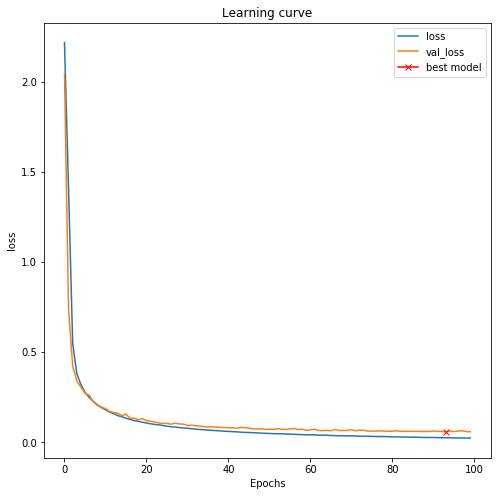

In [18]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss'] 
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [23]:
# Find test loss and accuracy
score = model.evaluate(X_test, Y_test, verbose=0) # accuracy check
print('Test loss:', score[0], 'Accuracy:', score[1]) 

Test loss: 0.06623497586597556 Accuracy: 0.98


In [26]:
# Testing
test_data = np.genfromtxt('test.csv', delimiter = ',')
test_data = test_data[1:]

In [27]:
print(test_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1) 
test_data = test_data.astype('float32')

test_data /= 255

In [30]:
predictions = model.predict_classes(test_data)
print(predictions)

[2 0 9 ... 3 9 2]


In [32]:
output=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "Label": predictions})
output.to_csv("submission.csv", index=False, header=True)